In [67]:
import os, sys
sys.path.append("../")
from utility import utils as uu
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy
from collections import OrderedDict

# Train/Val Loss

In [91]:
loss_palette = {
    "PT_Scratch": "black",
    "PT_SimCLR_I1k": "red",
    "PT_SimCLR_R": "cornflowerblue",
    "PT_SimCLR_RF": "blue"
}

ttc_palette = {
    "PT_Scratch": "gray",
    "PT_SimCLR_I1k": "red",
    "PT_SimCLR_R": "cornflowerblue",
    "PT_SimCLR_RF": "blue"
}

pt_names = {
    "E1": {
        "PT_Scratch": "No pretraining (random init)",
        "PT_SimCLR_I1k": "Pretrained on ImageNet-1k",
        "PT_SimCLR_R": "Pretrained on RadNet-1.28M",
        "PT_SimCLR_RF": "Pretrained on RadNet-12M"
    },
    "E2": {
        "PT_Scratch": "No pretraining (random init)",
        "PT_SimCLR_I1k": "Pretrained on ImageNet-1k",
        "PT_SimCLR_R": "Pretrained on RadNet-1.28M",
        "PT_SimCLR_RF": "Pretrained on RadNet-12M"
    },
    "E4": {
        "PT_SimCLR_I1k": "Pretrained on ImageNet-1k",
        "PT_SimCLR_R": "Pretrained on RadNet-1.28M",
        "PT_SimCLR_RF": "Pretrained on RadNet-12M"
    },
}

ft_names = {
    "E1": [
        "FT_BraTS",
        "FT_CX8",
        "FT_I1k",
        "FT_LiTS",
        "FT_R",
    ],
    "E2": [
        "FT_BraTSM",
        "FT_BraTSS",
        "FT_CX8M",
        "FT_CX8S",
        "FT_I1kS",
        "FT_I1kXS",
        "FT_I100",
        "FT_I100S",
        "FT_I100XS",
        "FT_I10",
        "FT_I10S",
        "FT_I10XS",
        "FT_LiTSM",
        "FT_LiTSS",
        "FT_RS",
        "FT_RXS",
        "FT_RXXS",
    ],
    "E4": [
        "FT_BraTS_lineval",
        "FT_CX8_lineval",
        "FT_I1k_lineval",
        "FT_LiTS_lineval",
        "FT_R_lineval",
    ]
}

ft_names_long = {
    "FT_CX8": "ChestX-ray8",
    "FT_CX8M": "ChestX-ray8 (50%)",
    "FT_CX8S": "ChestX-ray8 (10%)",
    "FT_CX8_lineval": "ChestX-ray8 (linear eval)",
    "FT_I1k": "ImageNet-1k",
    "FT_I1kS": "ImageNet-1k (10%)",
    "FT_I1kXS": "ImageNet-1k (1%)",
    "FT_I100": "ImageNet-100",
    "FT_I100S": "ImageNet-100 (10%)",
    "FT_I100XS": "ImageNet-100 (1%)",
    "FT_I10": "ImageNet-10",
    "FT_I10S": "ImageNet-10 (10%)",
    "FT_I10XS": "ImageNet-10 (1%)",
    "FT_I1k_lineval": "ImageNet-1k (linear eval)",
    "FT_R": "RadNet-1.28M",
    "FT_RS": "RadNet-1.28M (10%)",
    "FT_RXS": "RadNet-1.28M (1%)",
    "FT_RXXS": "RadNet-1.28M (0.1%)",
    "FT_R_lineval": "RadNet-1.28M (linear eval)",
    "FT_LiTS": "LiTS",
    "FT_LiTSM": "LiTS (50%)",
    "FT_LiTSS": "LiTS (10%)",
    "FT_LiTS_lineval": "LiTS (linear eval)",
    "FT_BraTS": "BraTS",
    "FT_BraTSM": "BraTS (50%)",
    "FT_BraTSS": "BraTS (10%)",
    "FT_BraTS_lineval": "BraTS (linear eval)",
}

max_steps_shown = {
        "E1": {
            "FT_BraTS": None,
            "FT_CX8": 1e5,
            "FT_I1k": 2e7,
            "FT_LiTS": 5e5,
            "FT_R": 2e7,
        },
        "E2": {
            "FT_BraTSM": None,
            "FT_BraTSS": None,
            "FT_CX8M": 1e5,
            "FT_CX8S": 1e5,
            "FT_I1kS": None,
            "FT_I1kXS": None,
            "FT_I100": None,
            "FT_I100S": None,
            "FT_I100XS": None,
            "FT_I10": None,
            "FT_I10S": None,
            "FT_I10XS": None,
            "FT_LiTSM": None,
            "FT_LiTSS": None,
            "FT_RS": None,
            "FT_RXS": None,
            "FT_RXXS": None,
        },
        "E4": {
            "FT_BraTS_lineval": None,
            "FT_CX8_lineval": 1e5,
            "FT_I1k_lineval": 2e7,
            "FT_LiTS_lineval": 5e5,
            "FT_R_lineval": 2e7,
        },
    }

In [92]:
def get_batch_size(e, pt_name, ft_name):
    path = f"../pkgs/FTE/config/{e}/{pt_name}_{ft_name}.yaml"
    with open(path, "r") as o:
        for line in o.readlines():
            if line.startswith("batch_size"):
                batch_size = int(line.split(": ")[-1])
    return batch_size

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

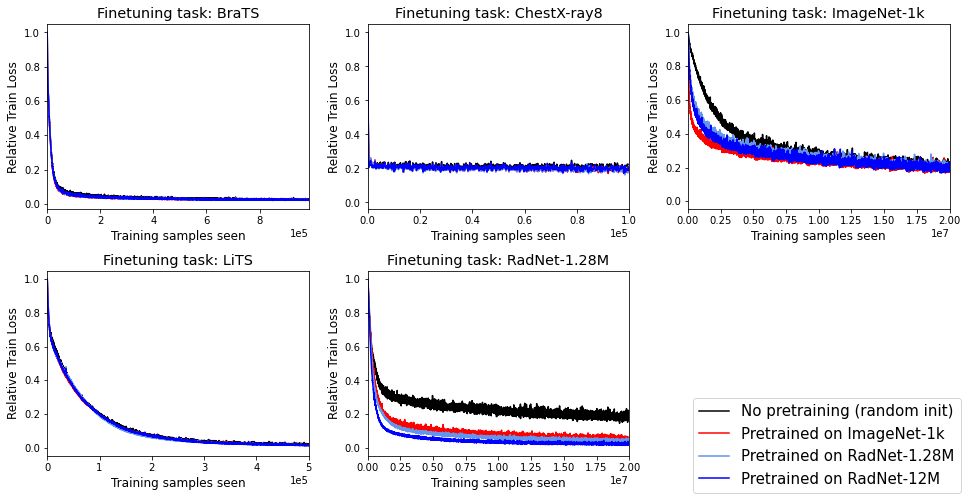

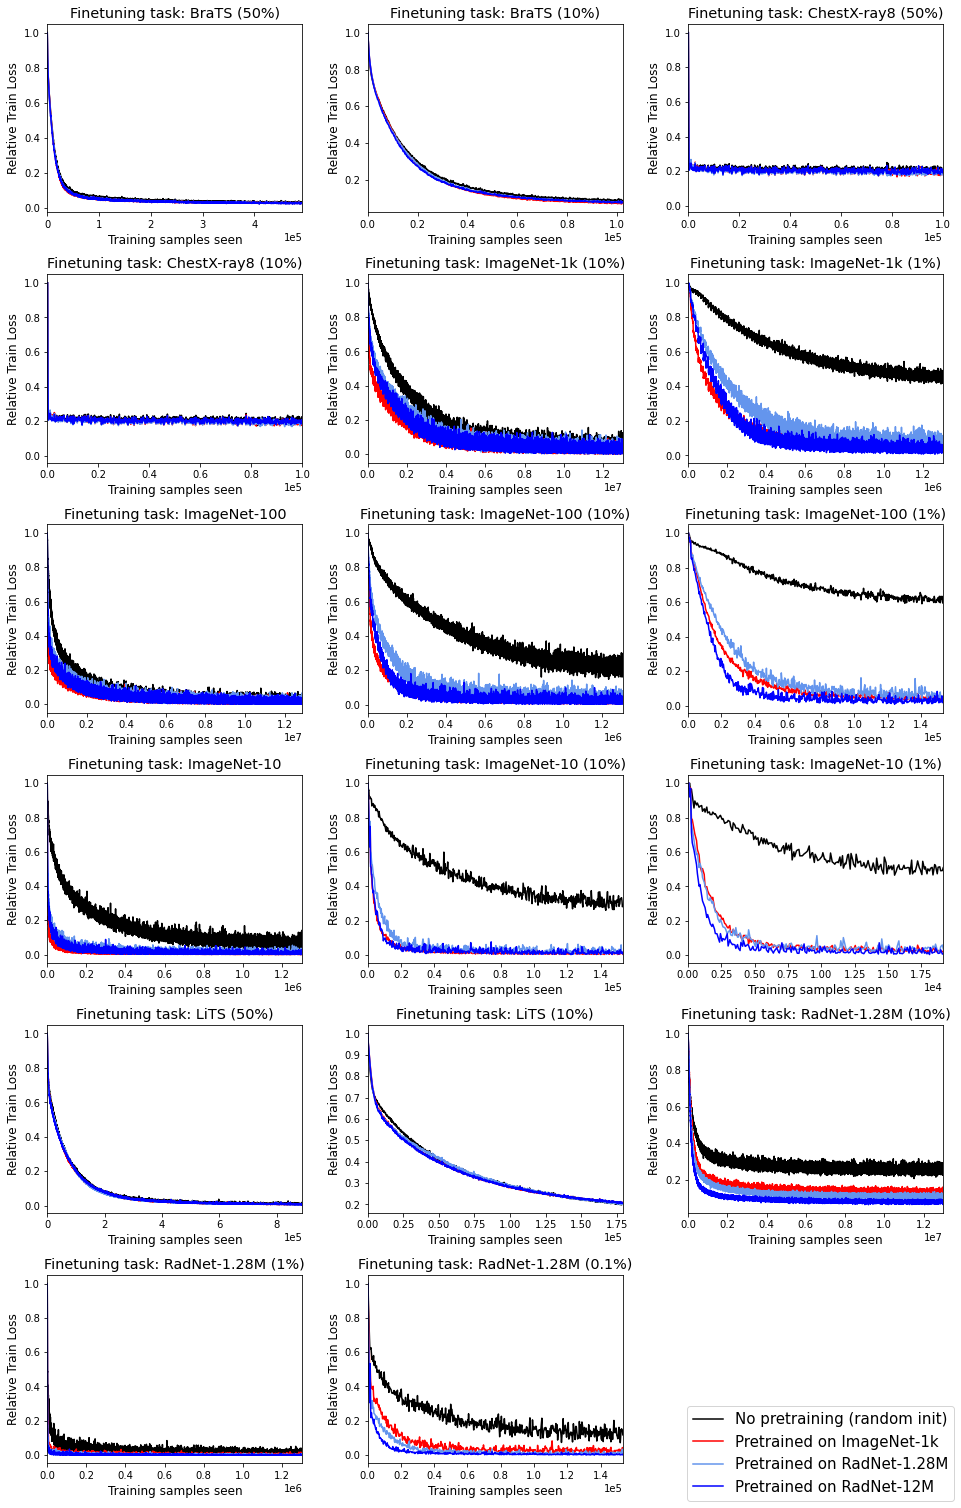

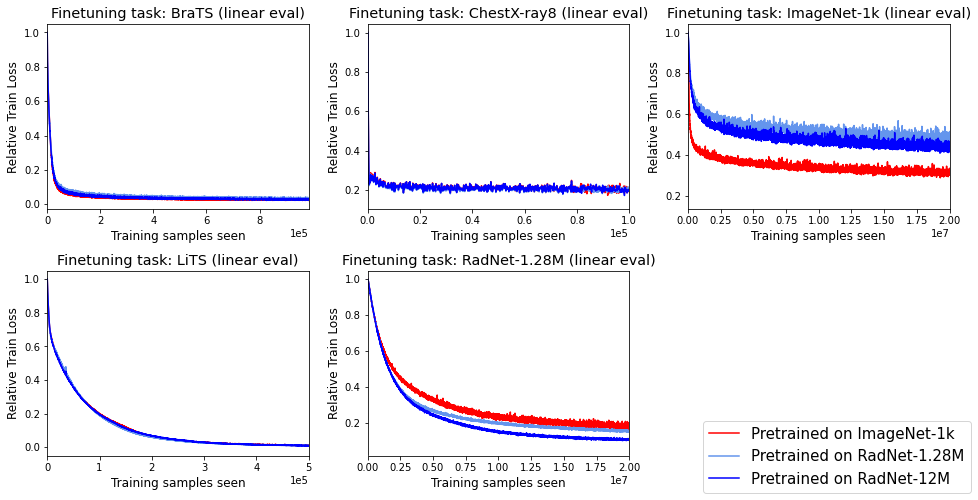

In [93]:
train_logs_files = {}
val_logs_files = {}

es = ["E1", "E2", "E4"]

for e in es:
    for pt_name in pt_names[e]:
        for ft_name in ft_names[e]:
            if not e in train_logs_files:
                train_logs_files[e] = {}
                val_logs_files[e] = {}
            train_logs_files[e][(pt_name, ft_name)] = f"../logs_and_checkpoints/finetuning/{e}/{pt_name}_{ft_name}/train.log"
            val_logs_files[e][(pt_name, ft_name)] = f"../logs_and_checkpoints/finetuning/{e}/{pt_name}_{ft_name}/val.log"

    train_logs = OrderedDict()
    epochs_shown = 100
    for (pn, fn), val in tqdm(train_logs_files[e].items()):
        train_log = pd.read_csv(val)
        train_log_f1 = pd.read_csv(val.replace("/train.log", "_f1/train.log", 1))
        train_log_f2 = pd.read_csv(val.replace("/train.log", "_f2/train.log", 1))
        train_log_f3 = pd.read_csv(val.replace("/train.log", "_f3/train.log", 1))
        train_log_concat = pd.concat((train_log, train_log_f1, train_log_f2, train_log_f3))
        train_log_concat = train_log_concat.groupby(train_log_concat.index)
        train_log = train_log_concat.mean()
        epochs_shown_eff = min(max(train_log["epoch"]), epochs_shown)
        ms = max(train_log["step"])
        train_log["step_sum"] = train_log["step"] + ms * (train_log["epoch"] - 1)
        bs = get_batch_size(e, pn, fn)
        train_log["seen_sum"] = (train_log["step"] + ms * (train_log["epoch"] - 1)) * bs
        train_log = train_log[train_log["epoch"] <= epochs_shown_eff]
        #train_log["interp_loss"] = np.interp(
        #    x = np.linspace(0, ms * bs, ((ms - 1) * epochs_shown_eff) + 1),
        #    xp = train_log["seen_sum"],
        #    fp = train_log["loss"]
        #    )
        if not e in train_logs:
            train_logs[e] = {}
        train_logs[e][(pn, fn)] = train_log

    ml = {}

    ncols = 3
    nrows = len(max_steps_shown[e])//ncols +1
    fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (4.5*ncols, 3.5*nrows))

    for (pn, fn), log in train_logs[e].items():
        if not (pn, fn) in ml:
            ml[(pn, fn)] = 0
        cml = max(log["loss"])
        if cml > ml[(pn, fn)]:
            ml[pn, fn] = cml
    for i, ((pn, fn), log) in enumerate(train_logs[e].items()):
        #print(i, pn, fn, (i % len(max_steps_shown[e])) // ncols, (i % len(max_steps_shown[e])) % ncols)
        ax = axes[(i % len(max_steps_shown[e])) // ncols, (i % len(max_steps_shown[e])) % ncols]
        ms = max(log["seen_sum"])
        ax.set_xlim(0, min(ms, (ms if max_steps_shown[e][fn] is None else max_steps_shown[e][fn])))
        ax.set_xlabel("Training samples seen")
        ax.set_ylabel("Relative Train Loss")
        ax.set_title(f"Finetuning task: {ft_names_long[fn]}")
        plt.rcParams.update({'axes.titlesize': 'x-large'})
        plt.rcParams.update({'axes.labelsize': 'large'})
        #if fn == "FT_I10XS" and pn == "PT_SimCLR_I1k":
            #print(log["seen_sum"], log["loss"], log["interp_loss"])
        ax.plot(
            log["seen_sum"],
            #log["interp_loss"] / ml[(pn, fn)],
            log["loss"] / ml[(pn, fn)],
            c = loss_palette[pn],
            label = pt_names[e][pn]
            )
        ax.ticklabel_format(axis = "x", style = "scientific", scilimits = (0, 0))
        ax.set_visible(True)
    fig.delaxes(axes[nrows - 1][ncols - 1])
    handles, labels = axes[0, 0].get_legend_handles_labels()
    legend = fig.legend(handles, labels, loc = 'lower right', prop = {'size': 15})
    fig.subplots_adjust(hspace = 1.0, wspace = 1.0)
    fig.tight_layout()
    # Save whole plot
    plt.savefig(f"./figures/{e}_TrainLossCurves.svg", format = "svg", bbox_inches = "tight")
    # Save just the legend
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent()
    bbox = bbox.from_extents(*(bbox.extents + np.array([-5, -5, 5, 5])))
    bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(f"./figures/{e}_TrainLossCurves_legend.svg", dpi = "figure", bbox_inches = bbox.expanded(1.25, 1.25))

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

<ipython-input-81-8ce2a68d4fb6>:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize = (8, 4))


  0%|          | 0/15 [00:00<?, ?it/s]

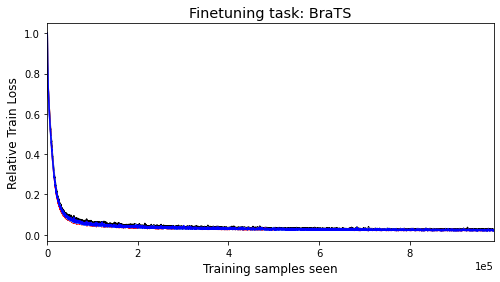

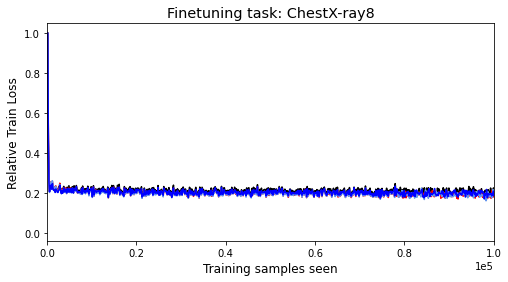

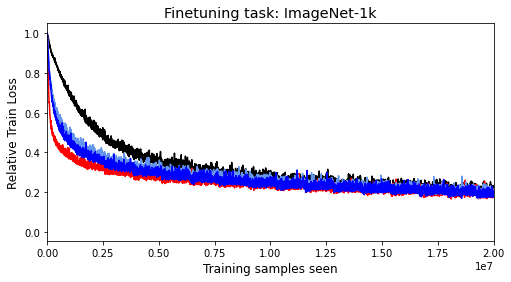

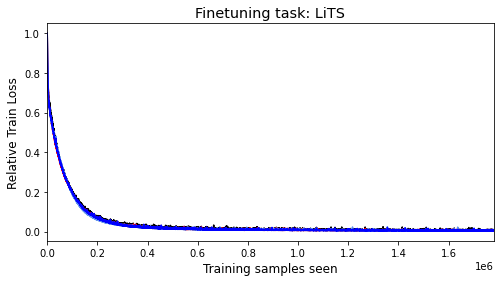

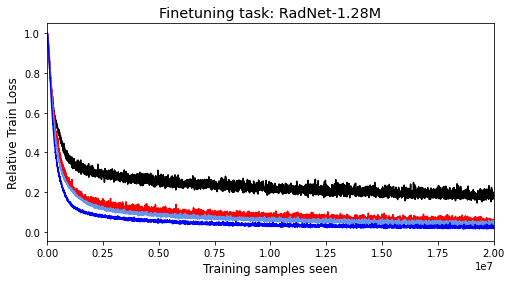

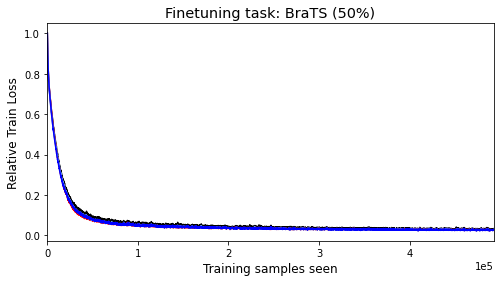

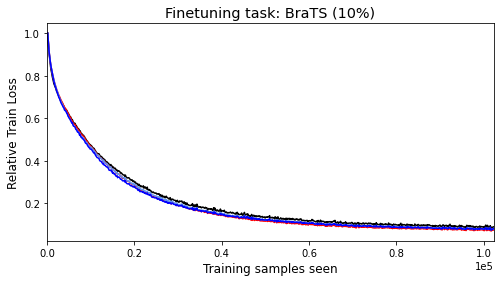

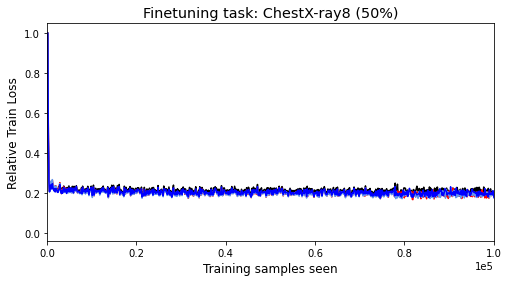

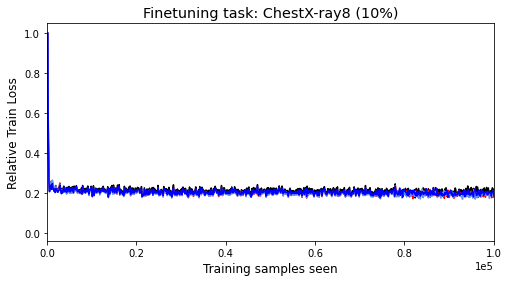

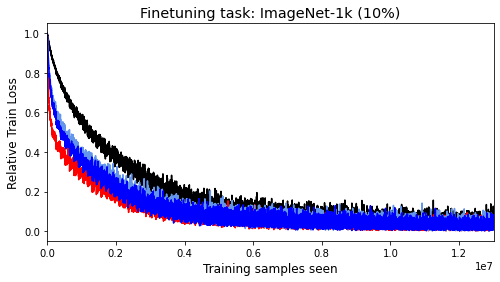

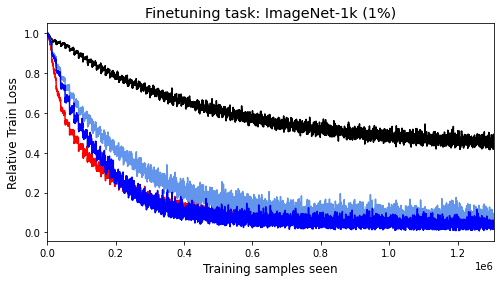

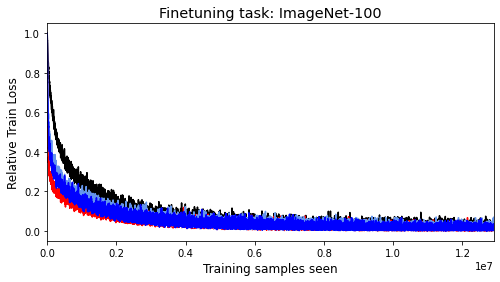

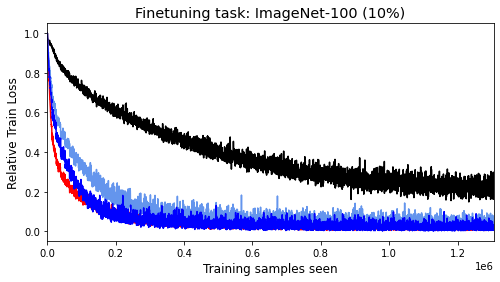

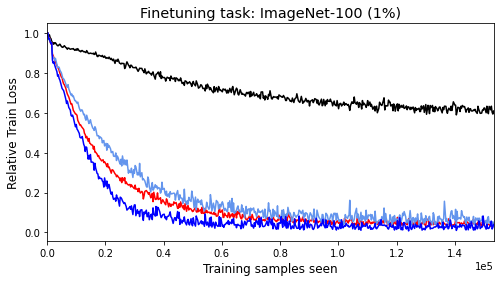

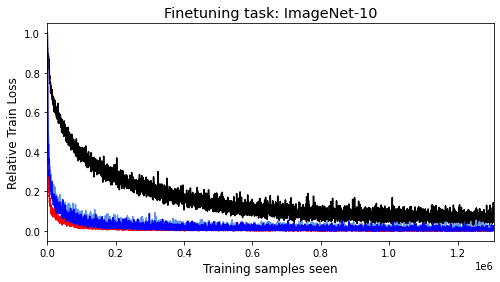

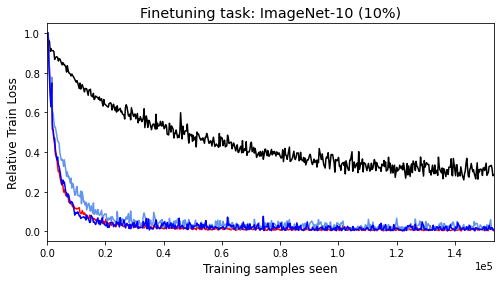

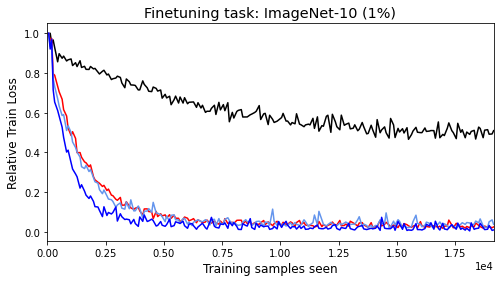

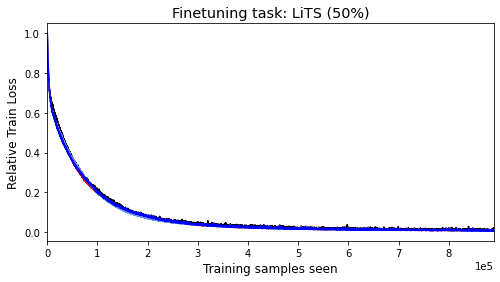

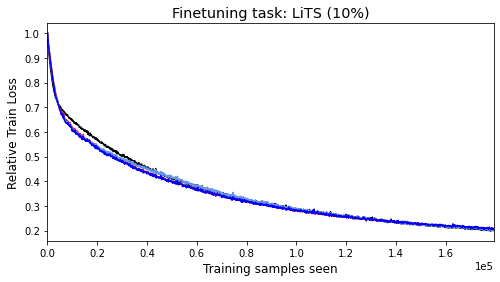

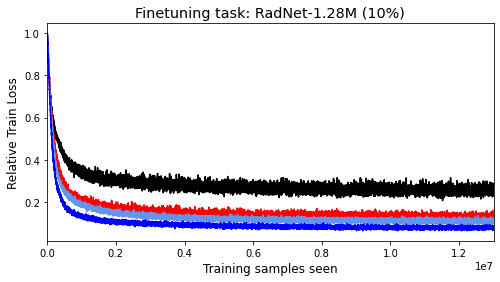

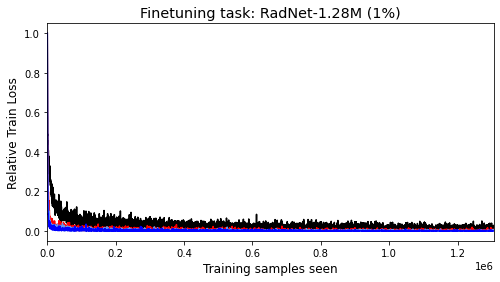

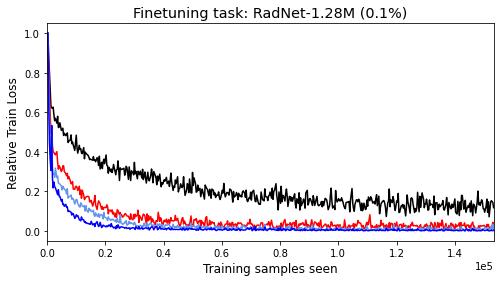

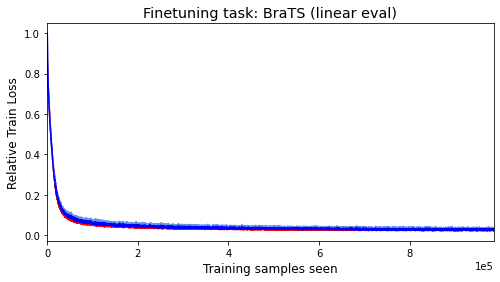

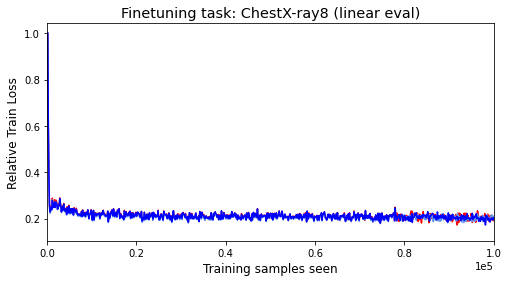

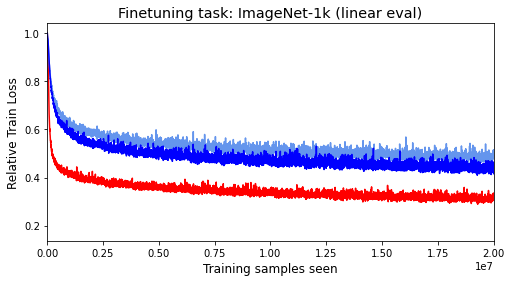

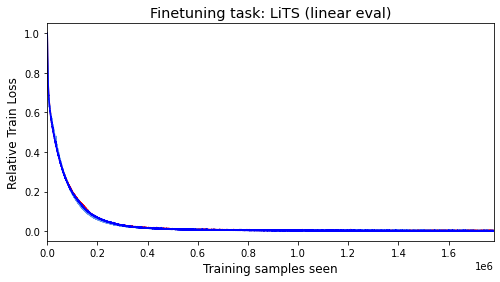

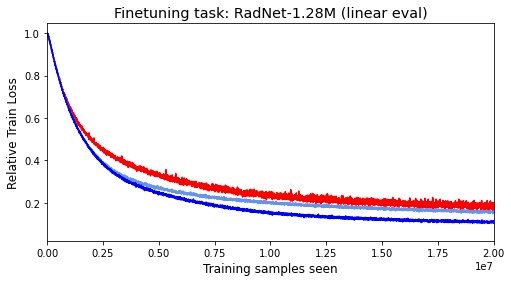

In [81]:
for e in es:

    train_logs = OrderedDict()
    epochs_shown = 100
    for (pn, fn), val in tqdm(train_logs_files[e].items()):
        train_log = pd.read_csv(val)
        train_log_f1 = pd.read_csv(val.replace("/train.log", "_f1/train.log", 1))
        train_log_f2 = pd.read_csv(val.replace("/train.log", "_f2/train.log", 1))
        train_log_f3 = pd.read_csv(val.replace("/train.log", "_f3/train.log", 1))
        train_log_concat = pd.concat((train_log, train_log_f1, train_log_f2, train_log_f3))
        train_log_concat = train_log_concat.groupby(train_log_concat.index)
        train_log = train_log_concat.mean()
        epochs_shown_eff = min(max(train_log["epoch"]), epochs_shown)
        ms = max(train_log["step"])
        train_log["step_sum"] = train_log["step"] + ms * (train_log["epoch"] - 1)
        bs = get_batch_size(e, pn, fn)
        train_log["seen_sum"] = (train_log["step"] + ms * (train_log["epoch"] - 1)) * bs
        train_log = train_log[train_log["epoch"] <= epochs_shown_eff]
        #train_log["interp_loss"] = np.interp(
        #    x = np.linspace(0, ms * bs, ((ms - 1) * epochs_shown_eff) + 1),
        #    xp = train_log["seen_sum"],
        #    fp = train_log["loss"]
        #    )
        if not e in train_logs:
            train_logs[e] = {}
        train_logs[e][(pn, fn)] = train_log

    ml = {}

    for (pn, fn), log in train_logs[e].items():
        if not (pn, fn) in ml:
            ml[(pn, fn)] = 0
        cml = max(log["loss"])
        if cml > ml[(pn, fn)]:
            ml[pn, fn] = cml
    for fn in ft_names[e]:
        fig = plt.figure(figsize = (8, 4))
        ax = plt.gca()
        plt.rcParams.update({'axes.titlesize': 'x-large'})
        plt.rcParams.update({'axes.labelsize': 'large'})
        ax.set_xlabel("Training samples seen")
        ax.set_ylabel("Relative Train Loss")
        ax.set_title(f"Finetuning task: {ft_names_long[fn]}")
        for i, ((cpn, cfn), log) in enumerate(train_logs[e].items()):
            if cfn != fn:
                continue
            ms = max(log["seen_sum"])
            ax.set_xlim(0, min(ms, (ms if max_steps_shown[e][cfn] is None else max_steps_shown[e][cfn])))
            ax.plot(
                log["seen_sum"],
                #log["interp_loss"] / ml[(cpn, cfn)],
                log["loss"] / ml[(cpn, cfn)],
                c = loss_palette[cpn],
                label = pt_names[e][cpn]
                )
        ax.ticklabel_format(axis = "x", style = "scientific", scilimits = (0, 0))
        ax.set_visible(True)
        # Save single plot
        plt.savefig(f"./figures/{e}_{fn}_TrainLossCurves.svg", format = "svg")

# TTC

In [8]:
ttc_metrics = {
    "CX8": ["auc_avg_overall"],
    "CX8M": ["auc_avg_overall"],
    "CX8S": ["auc_avg_overall"],
    "CX8_lineval": ["auc_avg_overall"],
    "I1k": ["acc"],
    "I1kS": ["acc"],
    "I1kXS": ["acc"],
    "I100": ["acc"],
    "I100S": ["acc"],
    "I100XS": ["acc"],
    "I10": ["acc"],
    "I10S": ["acc"],
    "I10XS": ["acc"],
    "I1k_lineval": ["acc"],
    "R": ["acc"],
    "RS": ["acc"],
    "RXS": ["acc"],
    "RXXS": ["acc"],
    "R_lineval": ["acc"],
    "LiTS": ["dice_avg_class_1"],
    "LiTSM": ["dice_avg_class_1"],
    "LiTSS": ["dice_avg_class_1"],
    "LiTS_lineval": ["dice_avg_class_1"],
    "BraTS": ["dice_avg_class_1"],
    "BraTSM": ["dice_avg_class_1"],
    "BraTSS": ["dice_avg_class_1"],
    "BraTS_lineval": ["dice_avg_class_1"],
}

  0%|          | 0/20 [00:00<?, ?it/s]

PT_Scratch, FT_BraTS, dice_avg_class_1 - TTC: 19.25
PT_Scratch, FT_CX8, auc_avg_overall - TTC: 15.0
PT_Scratch, FT_I1k, accuracy - TTC: 84.25
PT_Scratch, FT_LiTS, dice_avg_class_1 - TTC: 35.5
PT_Scratch, FT_R, acc - TTC: 4.5
PT_SimCLR_I1k, FT_BraTS, dice_avg_class_1 - TTC: 11.25
PT_SimCLR_I1k, FT_CX8, auc_avg_overall - TTC: 7.75
PT_SimCLR_I1k, FT_I1k, accuracy - TTC: 86.25
PT_SimCLR_I1k, FT_LiTS, dice_avg_class_1 - TTC: 8.0
PT_SimCLR_I1k, FT_R, acc - TTC: 3.25
PT_SimCLR_R, FT_BraTS, dice_avg_class_1 - TTC: 12.0
PT_SimCLR_R, FT_CX8, auc_avg_overall - TTC: 5.5
PT_SimCLR_R, FT_I1k, accuracy - TTC: 85.75
PT_SimCLR_R, FT_LiTS, dice_avg_class_1 - TTC: 8.0
PT_SimCLR_R, FT_R, acc - TTC: 1.75
PT_SimCLR_RF, FT_BraTS, dice_avg_class_1 - TTC: 12.25
PT_SimCLR_RF, FT_CX8, auc_avg_overall - TTC: 7.25
PT_SimCLR_RF, FT_I1k, accuracy - TTC: 83.75
PT_SimCLR_RF, FT_LiTS, dice_avg_class_1 - TTC: 12.75
PT_SimCLR_RF, FT_R, accuracy - TTC: 2.0


  0%|          | 0/68 [00:00<?, ?it/s]

PT_Scratch, FT_BraTSM, dice_avg_class_1 - TTC: 24.5
PT_Scratch, FT_BraTSS, dice_avg_class_1 - TTC: 33.25
PT_Scratch, FT_CX8M, auc_avg_overall - TTC: 5.5
PT_Scratch, FT_CX8S, auc_avg_overall - TTC: 11.0
PT_Scratch, FT_I1kS, accuracy - TTC: 84.25
PT_Scratch, FT_I1kXS, accuracy - TTC: 74.75
PT_Scratch, FT_I100, accuracy - TTC: 82.75
PT_Scratch, FT_I100S, accuracy - TTC: 55.75
PT_Scratch, FT_I100XS, accuracy - TTC: 76.5
PT_Scratch, FT_I10, accuracy - TTC: 40.75
PT_Scratch, FT_I10S, accuracy - TTC: 50.0
PT_Scratch, FT_I10XS, accuracy - TTC: 63.5
PT_Scratch, FT_LiTSM, dice_avg_class_1 - TTC: 47.25
PT_Scratch, FT_LiTSS, dice_avg_class_1 - TTC: 43.0
PT_Scratch, FT_RS, accuracy - TTC: 23.0
PT_Scratch, FT_RXS, accuracy - TTC: 5.0
PT_Scratch, FT_RXXS, accuracy - TTC: 22.5
PT_SimCLR_I1k, FT_BraTSM, dice_avg_class_1 - TTC: 15.25
PT_SimCLR_I1k, FT_BraTSS, dice_avg_class_1 - TTC: 32.75
PT_SimCLR_I1k, FT_CX8M, auc_avg_overall - TTC: 15.25
PT_SimCLR_I1k, FT_CX8S, auc_avg_overall - TTC: 11.75
PT_SimCLR_

<ipython-input-9-d39faadb5344>:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize = (4, 4))


  0%|          | 0/15 [00:00<?, ?it/s]

PT_SimCLR_I1k, FT_BraTS_lineval, dice_avg_class_1 - TTC: 15.0
PT_SimCLR_I1k, FT_CX8_lineval, auc_avg_overall - TTC: 22.0
PT_SimCLR_I1k, FT_I1k_lineval, accuracy - TTC: 73.0
PT_SimCLR_I1k, FT_LiTS_lineval, dice_avg_class_1 - TTC: 11.75
PT_SimCLR_I1k, FT_R_lineval, accuracy - TTC: 29.5
PT_SimCLR_R, FT_BraTS_lineval, dice_avg_class_1 - TTC: 6.5
PT_SimCLR_R, FT_CX8_lineval, auc_avg_overall - TTC: 20.5
PT_SimCLR_R, FT_I1k_lineval, accuracy - TTC: 78.75
PT_SimCLR_R, FT_LiTS_lineval, dice_avg_class_1 - TTC: 10.25
PT_SimCLR_R, FT_R_lineval, accuracy - TTC: 22.5
PT_SimCLR_RF, FT_BraTS_lineval, dice_avg_class_1 - TTC: 6.5
PT_SimCLR_RF, FT_CX8_lineval, auc_avg_overall - TTC: 13.25
PT_SimCLR_RF, FT_I1k_lineval, accuracy - TTC: 76.0
PT_SimCLR_RF, FT_LiTS_lineval, dice_avg_class_1 - TTC: 11.5
PT_SimCLR_RF, FT_R_lineval, accuracy - TTC: 9.5


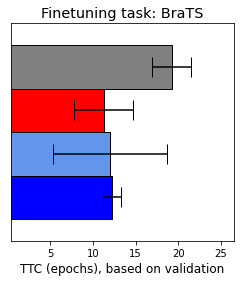

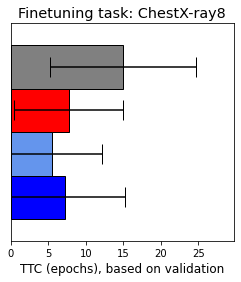

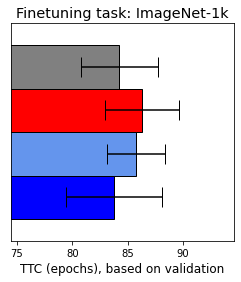

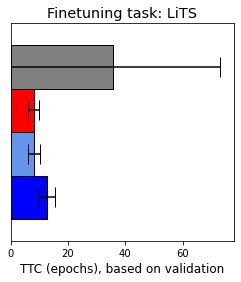

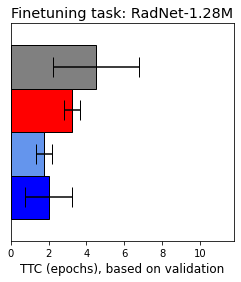

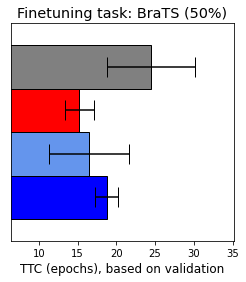

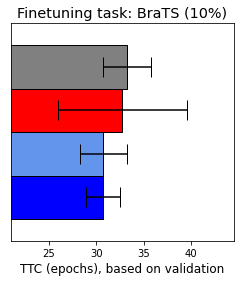

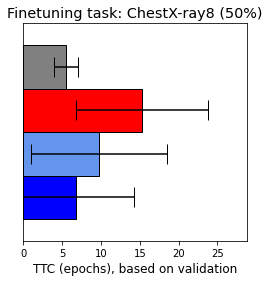

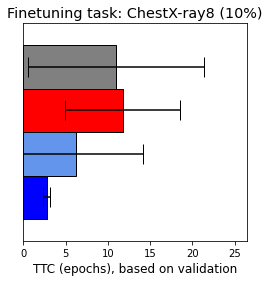

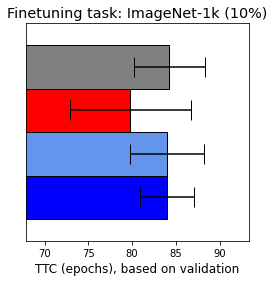

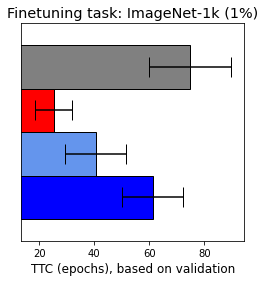

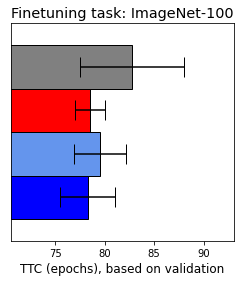

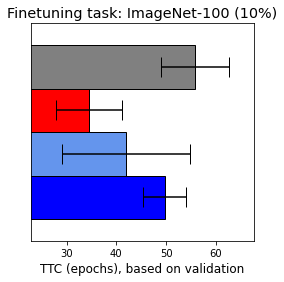

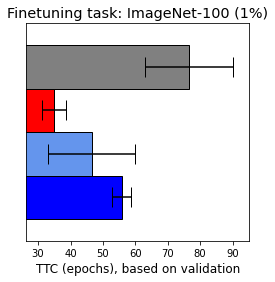

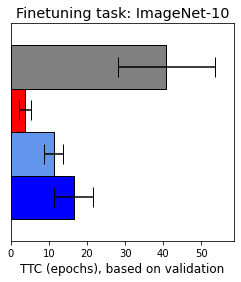

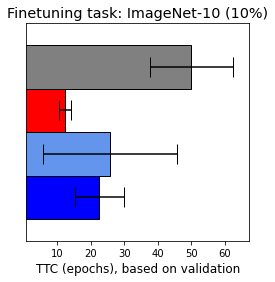

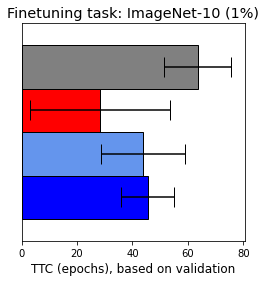

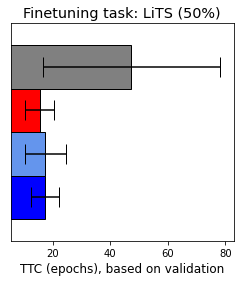

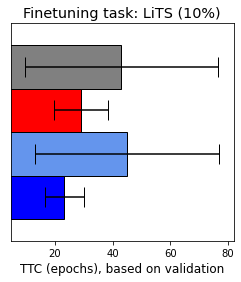

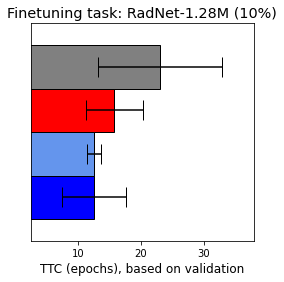

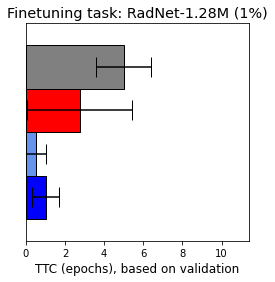

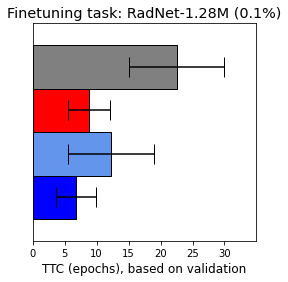

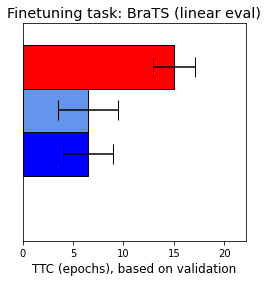

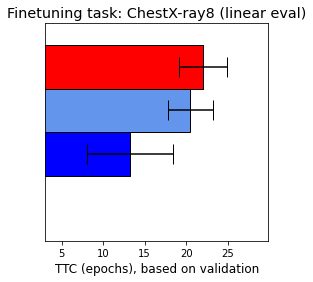

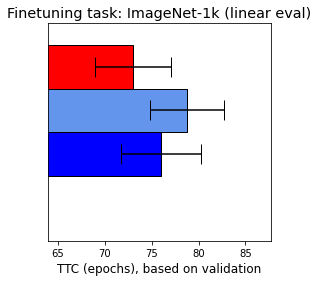

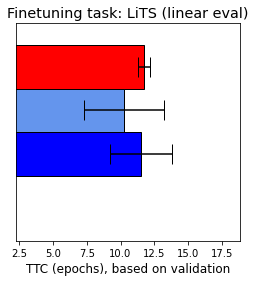

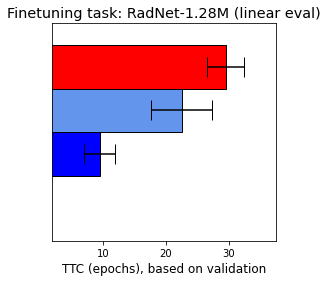

In [9]:
def time_to_convergence(arr, w = 10, s = 0.99):
    w2 = w // 2
    pos = [i + w2 + 1 for i in range(len(arr) - w2)]
    means = np.array([np.sum(arr[max(0, i - w2):min(len(arr), i + w2)]) / w for i in range(len(arr))])
    
    """
    for p in pos:
        if means[p]/means[-w2] >= s:
            # Converged approx. at:
            return p, means[p], means[-w2]
    # Found no convergence
    return np.nan, np.nan, means[-w2]
    """

    for p, a in enumerate(arr):
        if abs(a - means[-w2]) / means[-w2] <= 1-s:
            return p, m, means[-w2] # converged
        if p >= len(arr) - w2:
            return 100, np.nan, means[-w2] # not fully converged or very noisy

s = 0.995
for e in es:
    ttc_means = {}
    ttc_stds = {}
    for (pn, fn), val in tqdm(val_logs_files[e].items()):
        for m in ttc_metrics[fn[3:]]:
            ttcs = []
            for run in ["/val.log", "_f1/val.log", "_f2/val.log", "_f3/val.log"]:
                val_log = pd.read_csv(val.replace("/val.log", run, 1))
                try:
                    if m == "acc" and not "acc" in val_log.columns:
                        m = "accuracy"
                    if m == "accuracy" and not "accuracy" in val_log.columns:
                        m = "acc"
                    ct, cv, cvt = time_to_convergence(val_log[m], s = s)
                    ttcs.append(ct)
                except IndexError:
                    ttcs.append(100) # incomplete log (wait for remaining runs to finish)
            ttc_mean = np.mean(ttcs)
            ttc_std = np.std(ttcs)
            ttc_means[(pn, fn)] = ttc_mean
            ttc_stds[(pn, fn)] = ttc_std
            print(f"{pn}, {fn}, {m} - TTC: {ttc_means[(pn, fn)]}")
    for fn in ft_names[e]:
        ypos = [x*0.5+0.5 for x in range(len(pt_names[e]))]
        means = [ttc_means[(pn, fn)] for pn in pt_names[e]]
        stds = [ttc_stds[(pn, fn)] for pn in pt_names[e]]
        max_ext = [m+s for m, s in zip(means, stds)]
        min_ext = [m-s for m, s in zip(means, stds)]

        fig = plt.figure(figsize = (4, 4))
        plt.rcParams.update({"errorbar.capsize": 10})
        plt.title(f"Finetuning task: {ft_names_long[fn]}")
        plt.xlabel("TTC (epochs), based on validation")
        plt.ylim(0, 2.5)
        plt.xlim(max(0, min(min_ext) - 5), max(max_ext)+5)
        fig.axes[0].get_yaxis().set_visible(False)
        ax.axvline(max(means), linestyle = "--", c = "gray", alpha = 0.5) 
        plt.barh(
            ypos,
            means, 
            xerr = [ttc_stds[(pn, fn)] for pn in pt_names[e]],
            color = [ttc_palette[pn] for pn in pt_names[e]],
            edgecolor = "k",
            linewidth = 1,
            height = 0.5,
            align = "center"
            )
        fig.axes[0].invert_yaxis()
        plt.savefig(f"./figures/{e}_{fn}_TTC.svg", format = "svg", bbox_inches = "tight")

  0%|          | 0/8 [00:00<?, ?it/s]

0         0.000000
1         0.003322
2         0.006645
3         0.009967
4         0.013289
           ...    
29996    99.980066
29997    99.983389
29998    99.986711
29999    99.990033
30000    99.993355
Name: epoch_frac, Length: 30001, dtype: float64


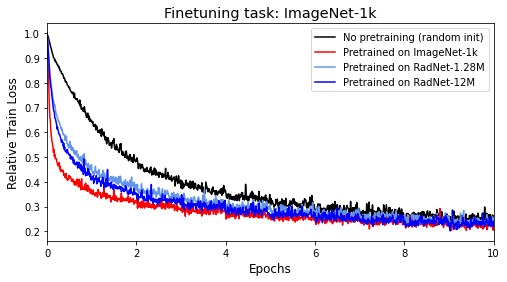

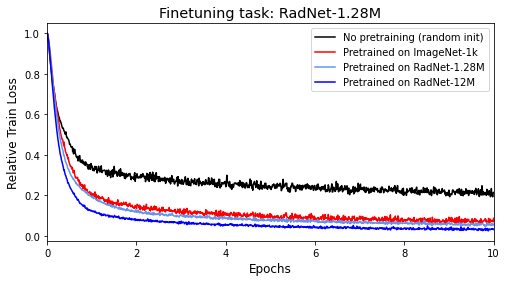

In [90]:
ft_names = {
    "E1": [
        "FT_I1k",
        "FT_R",
    ]}
train_logs_files = {}
val_logs_files = {}
interp_values = {}

e = "E1"
for pt_name in pt_names[e]:
    for ft_name in ft_names[e]:
        if not e in train_logs_files:
            train_logs_files[e] = {}
            val_logs_files[e] = {}
        train_logs_files[e][(pt_name, ft_name)] = f"../logs_and_checkpoints/finetuning/{e}/{pt_name}_{ft_name}/train.log"
        val_logs_files[e][(pt_name, ft_name)] = f"../logs_and_checkpoints/finetuning/{e}/{pt_name}_{ft_name}/val.log"

train_logs = {}
epochs_shown = 10
for (pn, fn), val in tqdm(train_logs_files[e].items()):
    interp_values[(e, pn, fn)] = {}
    train_log = pd.read_csv(val)
    train_log_f1 = pd.read_csv(val.replace("/train.log", "_f1/train.log", 1))
    train_log_f2 = pd.read_csv(val.replace("/train.log", "_f2/train.log", 1))
    train_log_f3 = pd.read_csv(val.replace("/train.log", "_f3/train.log", 1))
    train_log_concat = pd.concat((train_log, train_log_f1, train_log_f2, train_log_f3))
    train_log_concat = train_log_concat.groupby(train_log_concat.index)
    train_log = train_log_concat.mean()
    ms = max(train_log["step"])
    train_log["epoch_frac"] = train_log["epoch"]-1 + ((train_log["step"]-1) / ms)
    interp_values[(e, pn, fn)]["interp_loss"] = np.interp(
            x = np.linspace(0, 10, 1000),
            xp = train_log["epoch_frac"],
            fp = train_log["loss"],
            )
    interp_values[(e, pn, fn)]["epoch_frac"] = np.linspace(0, 10, 1000)
    #train_log["rel_loss"] = train_log["loss"] / max(train_log["loss"])
    if not e in train_logs:
        train_logs[e] = {}
    train_logs[e][(pn, fn)] = train_log

ml = {}
print(train_log["epoch_frac"])


#fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 5))

for (pn, fn), log in train_logs[e].items():
    if not (pn, fn) in ml:
        ml[(pn, fn)] = 0
    cml = max(interp_values[(e, pn, fn)]["interp_loss"])
    if cml > ml[(pn, fn)]:
        ml[pn, fn] = cml
for fn in ft_names["E1"]:
    fig = plt.figure(figsize = (8, 4))
    ax = plt.gca()
    ax.set_xlim(0, 10)
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Relative Train Loss")
    ax.set_title(f"Finetuning task: {ft_names_long[fn]}")
    plt.rcParams.update({'axes.titlesize': 'x-large'})
    plt.rcParams.update({'axes.labelsize': 'large'})
    for i, ((cpn, cfn), log) in enumerate(train_logs[e].items()):
        if cfn != fn:
            continue
        ax.plot(
            interp_values[(e, cpn, fn)]["epoch_frac"],
            interp_values[(e, cpn, fn)]["interp_loss"] / ml[(cpn, fn)],
            c = loss_palette[cpn],
            label = pt_names[e][cpn]
            )
        ax.set_visible(True)
        ax.legend(loc = "upper right")
    plt.savefig(f"./figures/{e}_{fn}_EpochTrainLossCurves.svg", format = "svg")
